# Modèles de prédiction pour la variable : **SiteEnergyUse(kBtu)**

Cette variable exprime l'intensité de consommation d'énergie à la source (IUE) est la consommation d'énergie à la source d'une propriété divisée par sa surface de plancher brute. La consommation d'énergie à la source est l'énergie annuelle utilisée pour faire fonctionner la propriété, y compris les pertes de production, de transmission et de distribution. Source EUI est mesurée en milliers d'unités thermiques britanniques (kBtu) par pied carré.

* [Préparer les données pour les algorithmes de Machine Learning](#Préparer-les-données-pour-les-algorithmes-de-Machine-Learning)
* [Partie 1 : Séléction et entraînement des modèles de régression](#Partie-1-:-Séléction-et-entraînement-des-modèles-de-régression)
* [Partie 2 : Mesure de l'importance des variables](#Partie-2-:-Mesure-de-l'importance-des-variables)
* [Partie 3 : Influence de la variable **EneergieStarScore**](#Partie-3-:-Influence-de-la-variable-EneergieStarScore)
* [Partie 4 : Entraînement du meilleur estimateur avec y_SiteEnergyUse_log2](
#Partie-4-:-Entraînement-du-meilleur-estimateur-avec-y_SiteEnergyUse_log2)

In [1]:
import pandas as pd
import numpy as np

In [2]:
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [3]:
from sklearn import neighbors, metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

In [4]:
import timeit

In [5]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.express as px

In [6]:
from sklearn.preprocessing import StandardScaler

from sklearn import dummy

from sklearn import model_selection
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import VotingRegressor, BaggingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn import kernel_ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn import kernel_ridge

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVR

In [7]:
from sklearn.decomposition import PCA
from sklearn import decomposition

In [8]:
import shap

In [9]:
from sklearn.model_selection import learning_curve

- Fonctions utiles

In [10]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [11]:
def rmse(modele,X,y):
    emission_predictions = modele.predict(X)
    lin_mse = mean_squared_error(y, emission_predictions)
    return np.sqrt(lin_mse)

In [12]:
def calculModalites(df, column):
    mods = pd.DataFrame(df[df[column].notnull()][column].value_counts(normalize=False))
    modalites = pd.DataFrame(mods.values, index=mods.index, columns=['Nbre Modalité']).sort_index()
    modalites.index.names = ['Modalités']
    return modalites

In [13]:
def fitModel(model, grid_params):
    start_time = timeit.default_timer()
    gridModel = GridSearchCV(model,param_grid=grid_params,refit="r2",cv=5,scoring=score)
    gridModel.fit(X_train, y_train)
    y_pred = gridModel.predict(X_test)
    elapsed = timeit.default_timer() - start_time
    return gridModel, y_pred

In [14]:
def visualiser_erreur_modele(y_test, y_pred_dum, label):
    fig = plt.figure(figsize=(20,8))
    plt.title(label)
    plt.scatter(y_test,y_pred_dum,alpha=0.3,color='coral')
    plt.ylim([0, 200])
    plt.xlim([0, 200])
    plt.xlabel('vraies valeurs', fontsize=14,)
    plt.ylabel('valeurs prédites', fontsize=14)
    #plt.legend(loc="lower right")

In [15]:
def resultatsGridSearchCV(grid,algo):
    print ("Les meilleurs paramètres de l'algorithme " + algo +" sont : ",grid.best_params_)
    print("Résultats de la validation croisée de l'algorithme " + algo+" :")
    for mean_r2, std_r2, params in zip(
            grid.cv_results_['mean_test_r2'], 
            grid.cv_results_['std_test_r2'], 
            grid.cv_results_['params']           
        ):

        print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
            mean_r2,
            std_r2,
            params
        ) )
    for mean_mae, std_mae, params in zip(
            grid.cv_results_['mean_test_neg_mean_absolute_error'], 
            grid.cv_results_['std_test_neg_mean_absolute_error'], 
            grid.cv_results_['params']           
        ):

        print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
            mean_mae,
            std_mae,
            params
        ))
    for mean_rmse, std_rmse, params in zip(
            grid.cv_results_['mean_test_neg_root_mean_squared_error'], 
            grid.cv_results_['std_test_neg_root_mean_squared_error'], 
            grid.cv_results_['params']           
        ):

        print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
            mean_rmse,
            std_rmse,
            params
        ))

In [16]:
def visualiser_mesure_models(mesure, name):
    fig = plt.figure(figsize=(15,5))
    mesure = mesure.sort_values(ascending=True)
    sns.barplot(x = mesure.index, y = mesure.values,saturation=.5,palette="crest")
    plt.title('Performances des modèles')
    plt.xticks(rotation=45,fontsize=10)
    plt.xlabel('Modèles',fontsize=14)
    plt.ylabel(name,fontsize=14)

In [17]:
def getMetrics(y_vraies, y_predites, name_algo):    
    R2 = metrics.r2_score(y_vraies, y_predites)
    MSE = metrics.mean_squared_error(y_vraies, y_predites,squared=False)
    RMSE = np.sqrt(MSE)
    MAE = metrics.mean_absolute_error(y_vraies, y_predites)
    #MEDIANE = metrics.median_absolute_error(y_test, y_pred)
    
    mesures_principales[name_algo] = ("{:.2f}".format(R2),"{:.2f}".format(RMSE),"{:.2f}".format(MAE),"{:.2f}".format(elapsed))
    label = name_algo + " : R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}".format(R2,RMSE,MAE,elapsed)
    
    return R2, RMSE, MAE, label#,MEDIANE

In [18]:
def getMetricsGridSearchCV(gridSearchCV, name_algo):
    best_R2 = max(gridSearchCV.cv_results_['mean_test_r2'])
    best_RMSE = np.sqrt(min(gridSearchCV.cv_results_['mean_test_neg_root_mean_squared_error']))
    best_MAE = min(gridSearchCV.cv_results_['mean_test_neg_mean_absolute_error'])
    #best_MEDIANE = min(grid_pred_rdg.cv_results_['mean_test_neg_median_error'])

    #Ajouter l'algo dnas la dataframe mesures_principales
    mesures_principales[name_algo] = ("{:.2f}".format(best_R2),"{:.2f}".format(best_RMSE),"{:.2f}".format(best_MAE),"{:.2f}".format(elapsed))
    label = name_algo + " : R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}".format(best_R2,best_RMSE,best_MAE,elapsed)
    
    return best_R2, best_RMSE, best_MAE, label#,best_MEDIANE

In [19]:
def display_scree_plot(pca):
    fig = plt.figure(figsize=(15,10))
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [20]:
# Conversion en dataframe pandas
def conversionVarianceDF(test):
    pca_columns = ['F' + str(c) for c in range(1, test.shape[1]+1, 1)] # création d'une liste avec les noms de colonnes de PC1 à PC50
    X_pca = pd.DataFrame(test, columns=pca_columns) # création du dataframe
    return X_pca

In [21]:
Fonctionsdef curve_learning(model,X_train,y_train):

    train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=X_train, y=y_train,
                                                           cv=10, train_sizes=np.linspace(0.1, 1.0, 10),
                                                         n_jobs=1)
    #
    # Calculate training and test mean and std
    #
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    #
    # Plot the learning curve
    #
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title('Learning Curve')
    plt.xlabel('Training Data Size')
    plt.ylabel('Model accuracy')
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

In [22]:
pd.set_option('display.max_columns',111)

###### Chargement du jeu de données nettoyé

In [23]:
data_cleanned = pd.read_csv('data/Seattle_table.csv')

# Préparer les données pour les algorithmes de Machine Learning

- Variable cible : **SiteEnergyUse(kBtu)**

In [24]:
y_SiteEnergyUse = data_cleanned['SiteEnergyUse(kBtu)'].copy()
y_SiteEnergyUse_log2 = np.log2(1+y_SiteEnergyUse)

### Fractionnement de nos jeux de données en données d'entrînement et données de test

In [25]:
X_ESS = data_cleanned.drop(['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'], axis = 1).copy()
X = X_ESS.drop(['ENERGYSTARScore'], axis = 1).copy()

###### Standardisation des données

In [26]:
standardScaler = StandardScaler()
X_scaled = pd.DataFrame(standardScaler.fit_transform(X), columns=X.columns).copy()
X_ESS_scaled = pd.DataFrame(standardScaler.fit_transform(X_ESS), columns=X_ESS.columns).copy()

###### Préparer les données d'entrînement et les données de test

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_SiteEnergyUse, test_size=0.2, random_state=42)
X_ESS_train, X_ESS_test, y_ESS_train, y_ESS_test = train_test_split(X_ESS_scaled, y_SiteEnergyUse, test_size=0.2, random_state=42)

In [28]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1230, 29), (1230,), (308, 29), (308,))

# Partie 1 : Séléction et entraînement des modèles de régression

In [29]:
mesures_principales = pd.DataFrame(index=['R2', 'RMSE', 'MAE', 'runtime(en seconde)'])

In [30]:
score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}

### DummyRegressor

In [31]:
start_time = timeit.default_timer()
strategy = ['mean', 'median']
dum_params = {"strategy": strategy}
dum = dummy.DummyRegressor()
grid_dum = GridSearchCV(
        dum,
        dum_params,
        cv=10,
        refit="r2",
        scoring=score)
                                    
grid_dum.fit(X_train, y_train)
y_pred = grid_dum.predict(X_test)
elapsed = timeit.default_timer() - start_time 

best_R2, best_RMSE, best_MAE, label = getMetricsGridSearchCV(grid_dum, 'DummyRegressor')

R2 = 0.02, modèle non performant, prédit toujours la même valeur.

## Modèles régularisés

In [32]:
#Hyperparametres pour chaque type de modèle
alpha_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-2, 1, 4)
l1_ratio = [0.1, 0.5, 1.0, 2.0]
c_range = np.logspace(-2, 2, 6)
selection = ['cyclic', 'random']

param_grid = {'alpha': alpha_range, 'gamma': gamma_range, "max_iter": [20, 50,100]}
ridge_params = {'alpha': alpha_range, "max_iter": [15,20, 25]}
krr_params = {'kernel' : ('linear', 'rbf'), 'alpha': alpha_range, 'gamma': gamma_range}
lasso_params = {'alpha': alpha_range}
elastic_net_params = {'alpha':alpha_range}

param_grid_svr = {'kernel' : ('linear', 'rbf'), 'C' : c_range, 'coef0' : [0.01,0.5], 'gamma' : ('auto','scale')}


### Ridge

In [33]:
start_time = timeit.default_timer()
grid_rdg = GridSearchCV(
        Ridge(random_state=42),
        ridge_params,
        refit='r2',
        cv=5,  
        scoring= score)
                                    
grid_rdg.fit(X_train, y_train)
y_pred = grid_rdg.predict(X_test)
elapsed = timeit.default_timer() - start_time

best_R2, best_RMSE, best_MAE, label = getMetricsGridSearchCV(grid_rdg, 'Ridge')


### Lasso

In [34]:
start_time = timeit.default_timer()
grid_lasso = GridSearchCV(
        Lasso(random_state=42),
        lasso_params,
        refit='r2',
        cv=5,  
        scoring= score)
                                    
grid_lasso.fit(X_train, y_train)
y_pred = grid_lasso.predict(X_test)
elapsed = timeit.default_timer() - start_time

best_R2, best_RMSE, best_MAE, label = getMetricsGridSearchCV(grid_lasso, 'Lasso')


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.383e+15, tolerance: 3.389e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.129e+14, tolerance: 2.288e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.082e+15, tolerance: 3.317e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.536e+14, tolerance: 2.624e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.171e+15, tolerance: 3.084e+13
Objective did n

### ElasticNet

In [35]:
start_time_net = timeit.default_timer()
grid_elestic_net = GridSearchCV(
        ElasticNet(random_state=42),
        elastic_net_params,
        refit='r2',
        cv=5,  
        scoring= score)
                                    
grid_elestic_net.fit(X_train, y_train)
y_hat_net = grid_elestic_net.predict(X_test)
elapsed_time_net = timeit.default_timer() - start_time_net

best_R2, best_RMSE, best_MAE, label = getMetricsGridSearchCV(grid_elestic_net, 'ElasticNet')


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.623e+16, tolerance: 3.389e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.663e+16, tolerance: 2.288e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.658e+16, tolerance: 3.317e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.854e+16, tolerance: 2.624e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.790e+16, tolerance: 3.084e+13


### Ridgekernel

In [36]:
start_time = timeit.default_timer()
grid_krdg = GridSearchCV( 
        kernel_ridge.KernelRidge(),
        krr_params,
        cv=5,
        refit="r2",
        scoring=score)
                                    
grid_krdg.fit(X_train, y_train)
y_pred_krdg = grid_krdg.predict(X_test)
elapsed = timeit.default_timer() - start_time 

best_R2, best_RMSE, best_MAE, label = getMetricsGridSearchCV(grid_krdg, 'Ridgekernel')


## Modèles SVM

In [37]:
c_range = np.logspace(-2, 2, 6)
gamma_range = np.logspace(-2, 2, 6)

svr_params = [
        {'kernel': ['linear', 'rbf'], 'C': [1.0, 3.0, 30., 100., 300.],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]
        }
    ]

In [38]:
start_time = timeit.default_timer()
grid_svr = GridSearchCV(SVR(),param_grid=svr_params,refit="r2",cv=5,scoring=score)
grid_svr.fit(X_train, y_train)
y_pred = grid_svr.predict(X_test)
elapsed = timeit.default_timer() - start_time

best_R2, best_RMSE, best_MAE, label = getMetricsGridSearchCV(grid_svr, 'SVR')


### Méthode des k plus proches voisins

In [39]:
param_grid = {'n_neighbors': [2, 3, 5, 7, 9, 11, 13, 15], 'weights': ['uniform', 'distance'], 'p': [1,2]}

start_time = timeit.default_timer()
knn_reg = GridSearchCV(KNeighborsRegressor(),param_grid,refit='r2',cv=5,scoring=score)
knn_reg.fit(X_train, y_train)
y_pred = knn_reg.predict(X_test)
elapsed = timeit.default_timer() - start_time

best_R2, best_RMSE, best_MAE, label = getMetricsGridSearchCV(knn_reg, 'KNeighborsRegressor')



### RandomForest

In [40]:
rdf_params = {'bootstrap': [True],
              'n_estimators': [1000,1200], 
              'max_features': [29,30]
             }

forest_reg = RandomForestRegressor(random_state=42)
start_time = timeit.default_timer()
rnd_search = GridSearchCV(forest_reg, rdf_params, refit="r2",cv=5, scoring=score)
rnd_search.fit(X_train, y_train)
y_pred = rnd_search.predict(X_test)
elapsed = timeit.default_timer() - start_time

best_R2, best_RMSE, best_MAE, label = getMetricsGridSearchCV(rnd_search, 'RandomForest_1')



10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mel/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mel/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/mel/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/mel/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "

### GradientBoostingRegressor

In [41]:
subsample = [0.5,0.9,1.0]
n_estimators = [10,40,60,100,200]
max_depth = [5,10,15,20]
#learning_range = np.arange(0.01,0.11,0.01)
learning_range = np.arange(0.05,0.1,0.01)

param_grid = {'max_depth':max_depth,'learning_rate':learning_range,'subsample':subsample,'n_estimators':n_estimators}

start_time = timeit.default_timer()
grid_xboost = GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=5,
        refit="r2",
        scoring=score)
                            
grid_xboost.fit(X_train, y_train)
y_pred_xboost = grid_xboost.predict(X_test)
elapsed = timeit.default_timer() - start_time

best_R2, best_RMSE, best_MAE, label = getMetricsGridSearchCV(grid_xboost, 'GradientBoostingRegressor')


### Résultats de chaque modèle

In [42]:
mesures_principales

,DummyRegressor,Ridge,Lasso,ElasticNet,Ridgekernel,SVR,KNeighborsRegressor,RandomForest_1,GradientBoostingRegressor
R2,-0.05,0.40,0.38,0.39,0.43,-0.07,0.40,0.39,0.43
RMSE,3929.35,3512.46,3522.52,3515.53,3457.70,4131.92,3538.61,3466.14,3406.28
MAE,6264175.09,5407885.93,5443992.96,5419424.51,5196278.41,6073911.53,5296003.65,5294696.22,5230275.29
runtime(en seconde),0.03,0.22,0.41,0.41,5.25,14.24,1.16,39.62,270.18


In [43]:
R2 = mesures_principales.loc['R2'].astype(np.float64)
RMSE = mesures_principales.loc['RMSE'].astype(np.float64)
MAE = mesures_principales.loc['MAE'].astype(np.float64)

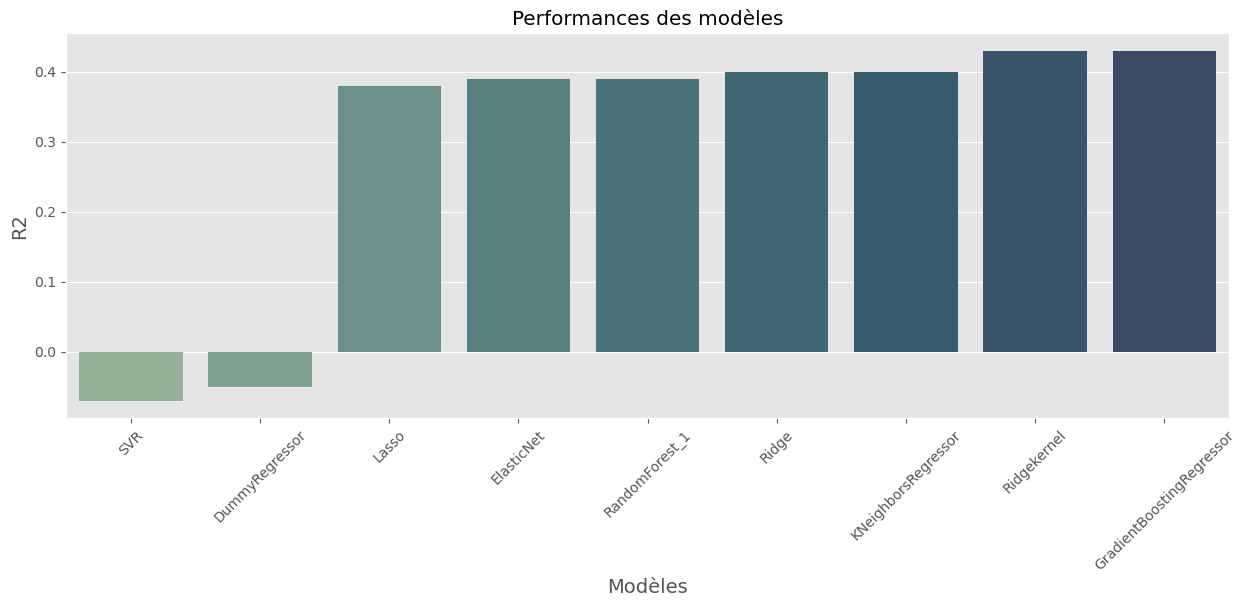

In [44]:
visualiser_mesure_models(R2, 'R2')

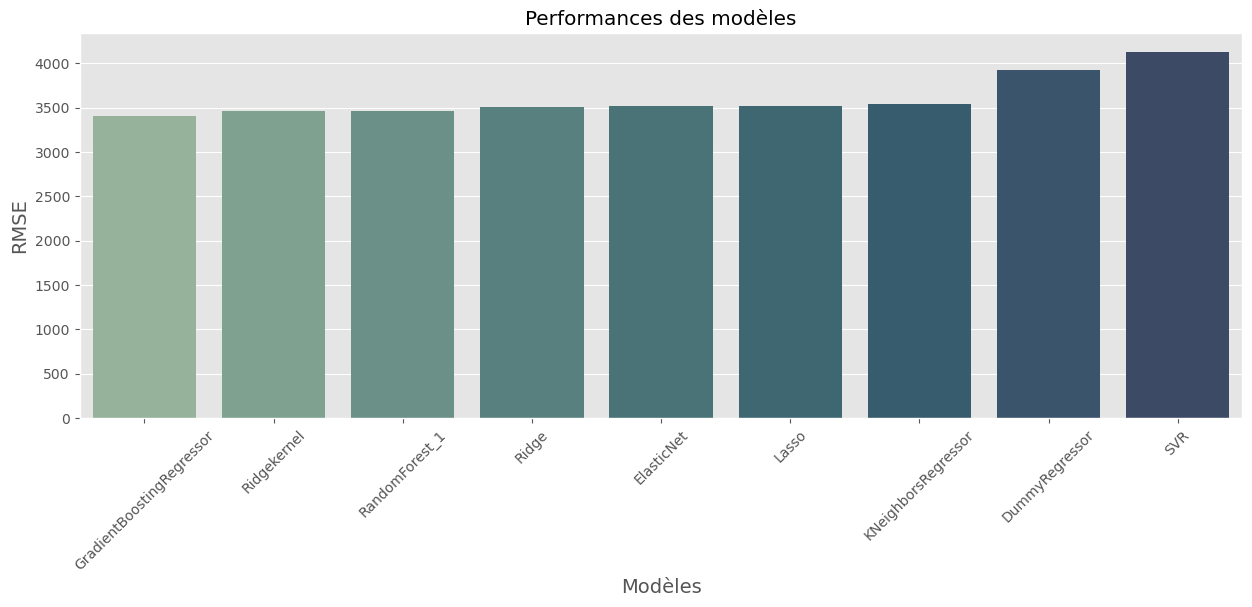

In [45]:
visualiser_mesure_models(RMSE, 'RMSE')

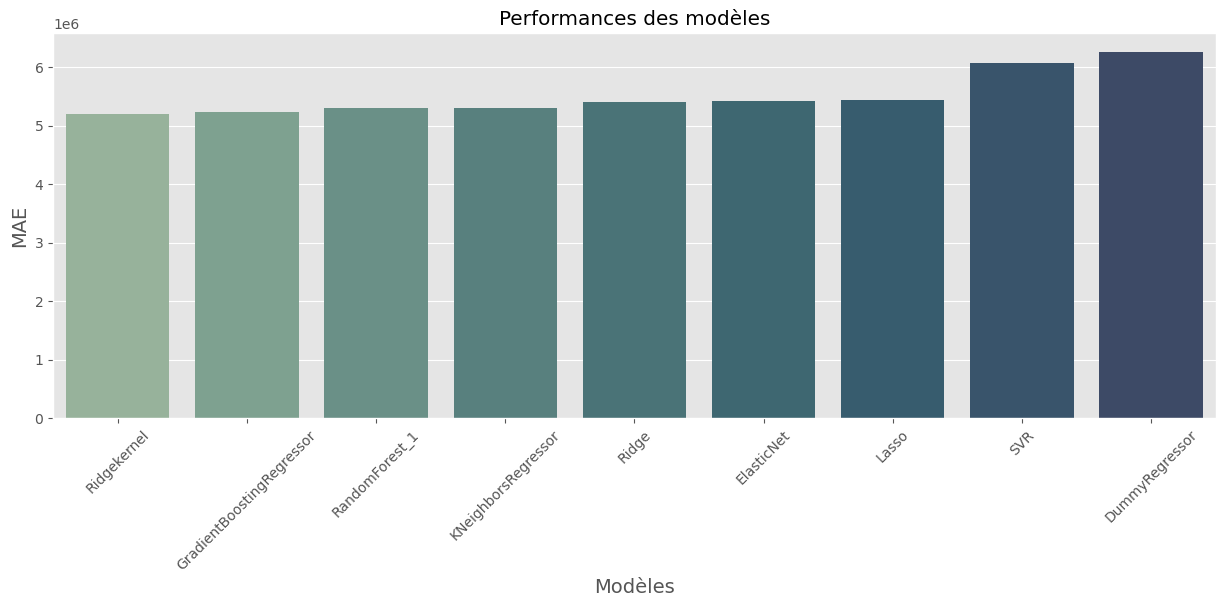

In [46]:
visualiser_mesure_models(MAE,'MAE')

In [47]:
mesures_principales.to_csv('data/mesures_principales_2.csv')

In [48]:
best_model = grid_xboost.best_estimator_
best_model_curve = grid_xboost.best_estimator_
best_model_ess = grid_xboost.best_estimator_
best_model_log = grid_xboost.best_estimator_

In [49]:
grid_xboost.best_params_

{'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 40, 'subsample': 0.5}

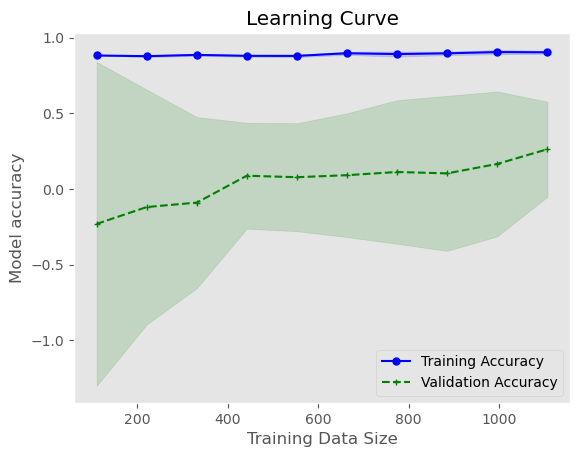

In [50]:
curve_learning(best_model_curve,X_train,y_train)

### Partie 2 : Mesure de l'importance des variables

In [51]:
# explainer
explainer = shap.Explainer(best_model.predict, X_test)
# Calcule les valeurs SHAP
shap_values = explainer(X_test)

Permutation explainer: 309it [00:13,  6.71it/s]                                 


- Evaluation des valeurs SHAP

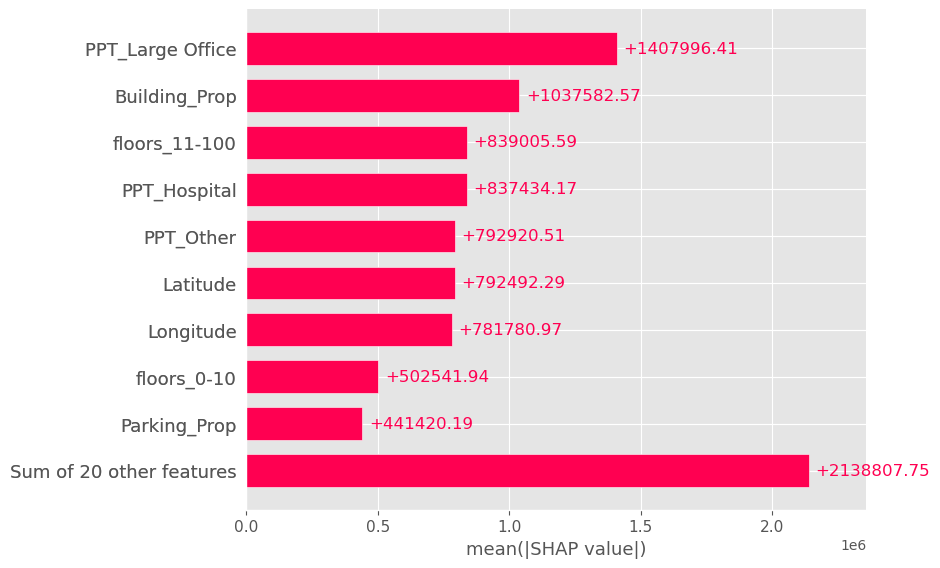

In [52]:
# Globale
shap.plots.bar(shap_values)

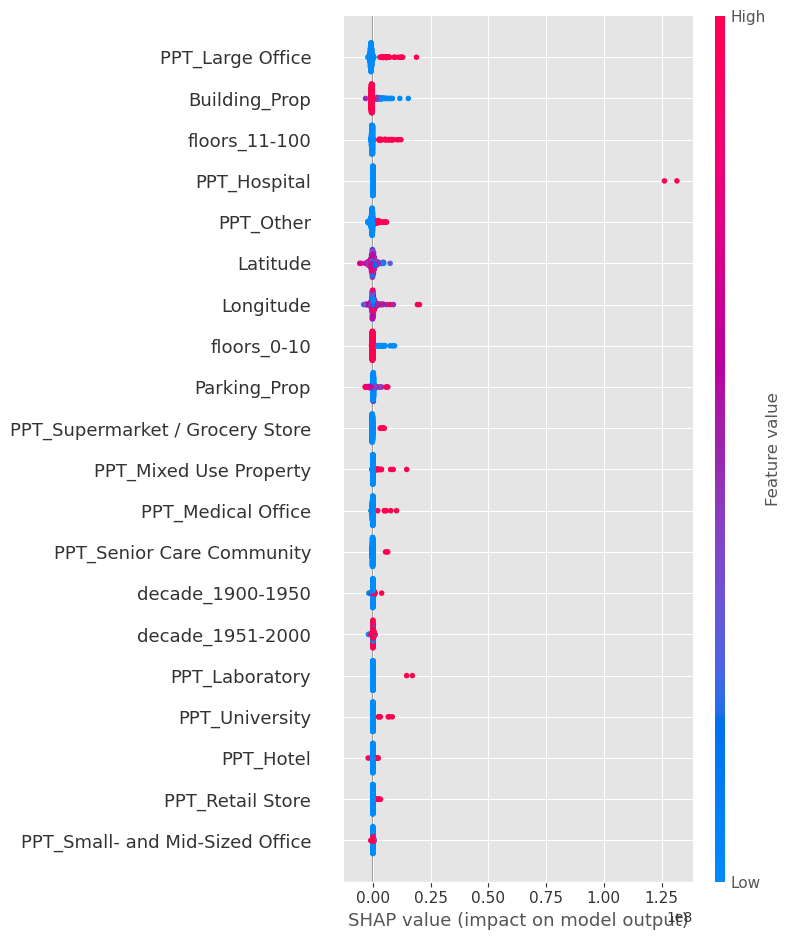

In [53]:
shap.summary_plot(shap_values)

On constate que les variables **SourceEUI(kBtu/sf)** et **NaturalGas(kBtu)** ont plus d'importance que le reste des autres variables

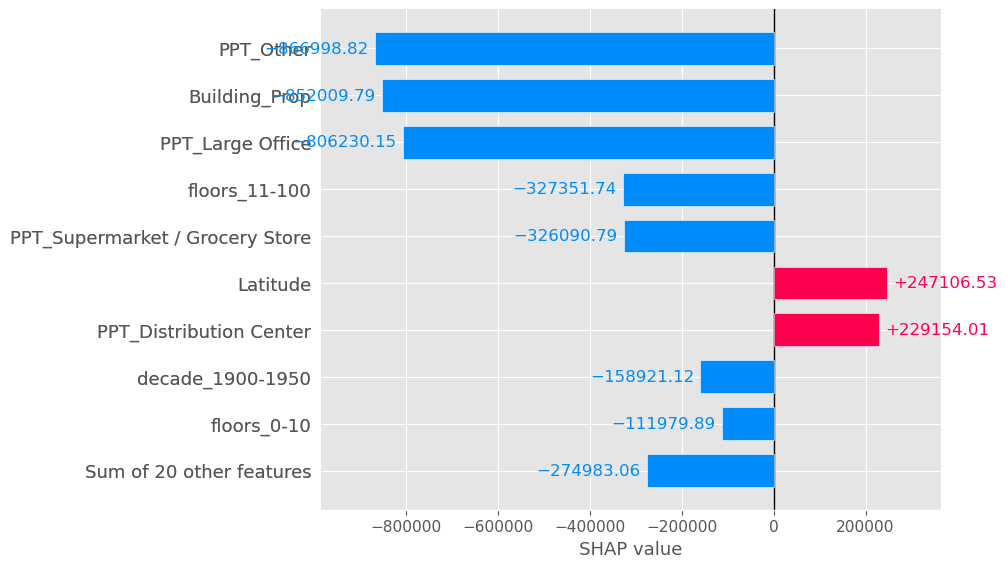

In [54]:
# Locale
shap.plots.bar(shap_values[0])

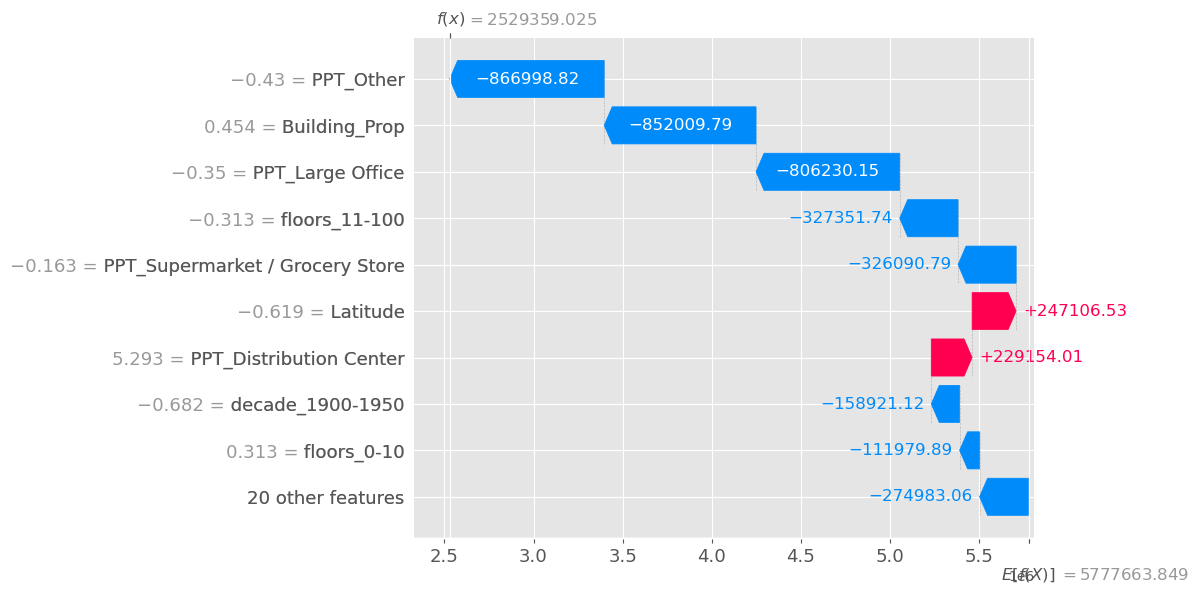

In [55]:
shap.plots.waterfall(shap_values[0])

On consate que les valeurs élevées des variables **NaturalGas(kBtu)** et **PropertyGFAParking** ont une influence positive, par contre les vaeurs basses des variables **PPT_Large Office** et **ThirdLargestPropertyUseTypeProp** ont une influence négative

### Partie 3 : Influence de la variable **EneergieStarScore**

-On ré-entraine le meilleur estimateur en introduisant la variable **EnergieScorStar**

In [56]:
start_time = timeit.default_timer()
best_model_ess.fit(X_ESS_train, y_ESS_train)
y_pred = best_model_ess.predict(X_ESS_test)
elapsed = timeit.default_timer() - start_time

best_R2, best_RMSE, best_MAE, label = getMetrics(y_ESS_test, y_pred, 'GradientBoostingRegressor_ESS')

In [57]:
mesures_principales[['GradientBoostingRegressor','GradientBoostingRegressor_ESS']]

,GradientBoostingRegressor,GradientBoostingRegressor_ESS
R2,0.43,0.42
RMSE,3406.28,4220.96
MAE,5230275.29,6171231.47
runtime(en seconde),270.18,0.13


- La variable **EneergieStarScore**  apporte une améliore pour les performances du modèle

### Partie 4 : Entraînement du meilleur estimateur avec y_SiteEnergyUse_log2

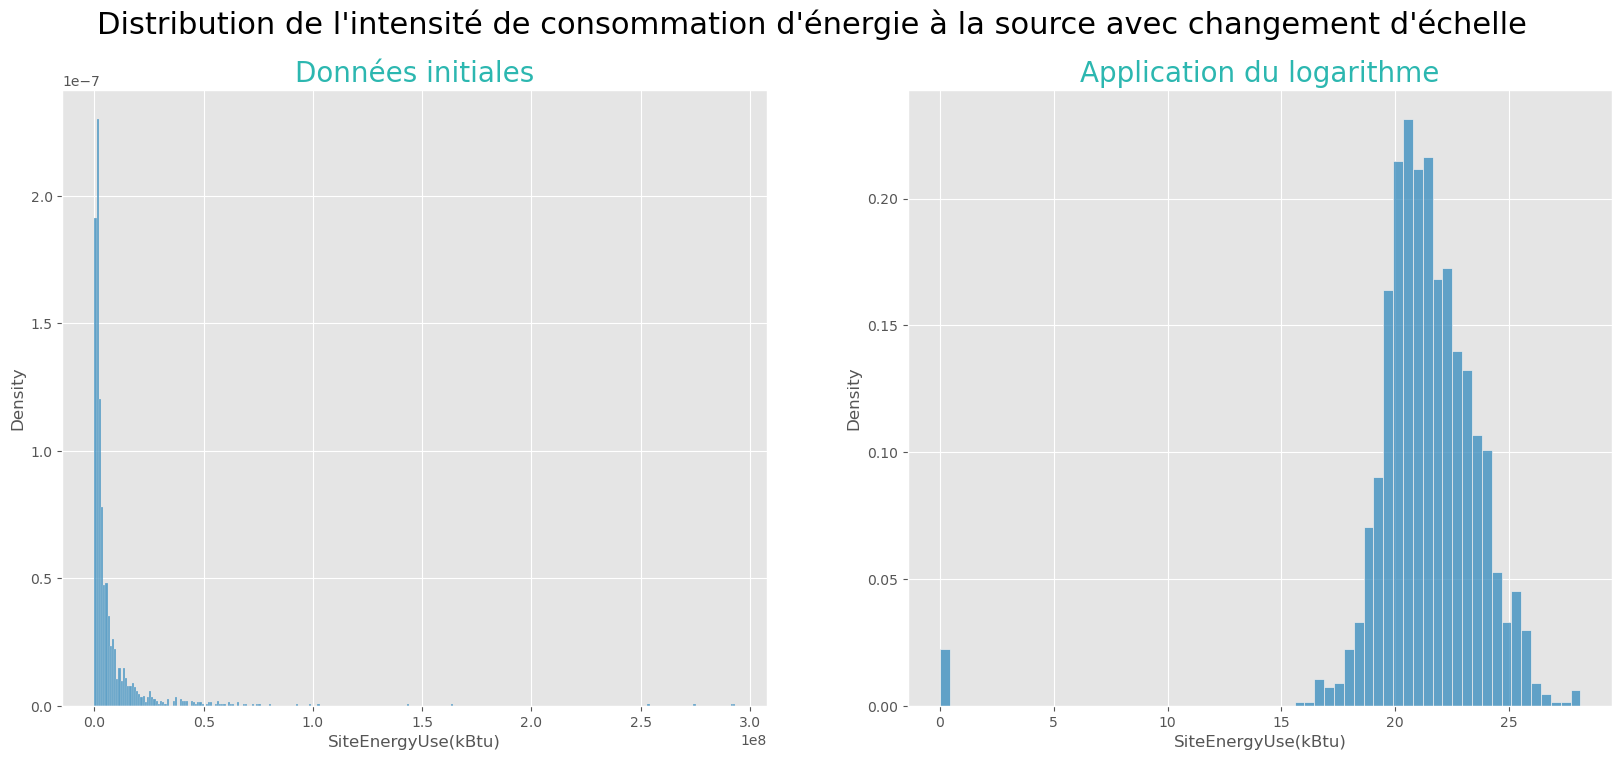

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=y_SiteEnergyUse, stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0', fontsize=20)
sns.histplot(data=y_SiteEnergyUse_log2, stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0', fontsize=20)
plt.suptitle("Distribution de l'intensité de consommation d'énergie à la source avec changement d'échelle", fontsize=22)
plt.show()

- En passant les données à l'échelle logarithmique, nous obtenons une distribution normale des données à prédire

In [59]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_scaled, y_SiteEnergyUse_log2, test_size=0.2, random_state=42)

In [60]:
start_time = timeit.default_timer()
best_model_log.fit(X_train_log, y_train_log)
y_pred_log = best_model_log.predict(X_test_log)
elapsed = timeit.default_timer() - start_time

R2, RMSE, MAE, label = getMetrics(y_test_log, y_pred_log, 'GradientBoostingRegressor_LOG')

#visualiser_erreur_modele(y_test, y_pred, label)

In [61]:
mesures_principales
mesures_principales[['GradientBoostingRegressor','GradientBoostingRegressor_LOG']]

,GradientBoostingRegressor,GradientBoostingRegressor_LOG
R2,0.43,0.15
RMSE,3406.28,1.44
MAE,5230275.29,1.37
runtime(en seconde),270.18,0.11


- On constate une amélioration des performances du modèle

## Fin